# Application of Gibbs Sampler to Image Denoising via Ising Model

<center> Author: Faisal Jayousi </center>

<center> Date: February 2024   </center>


**Abstract** This notebook explores the application of the Ising model and Gibbs sampling to the problem of binary image denoising. Given a noisy binary image $y\in\{-1,+1\}^\Lambda$, where $\Lambda$ is a 2D lattice, we aim to estimate the true (crisp) image $x\in\{-1,+1\}^\Lambda$. The Ising model defines an energy functional $H(x)$ that quantifies the interaction between neighbouring pixels, encouraging smoothness in the reconstructed image. The denoising problem is formulated as sampling from a posterior distribution $\pi(x|y)$. This is done using a Gibbs sampler here.

## Table of Contents

- [Application of Gibbs Sampler to Image Denoising via Ising Model](#application-of-gibbs-sampler-to-image-denoising-via-ising-model)
  - [Problem Setup](#problem-setup)
  - [Sampling from the posterior distribution](#sampling-from-the-posterior-distribution)
  - [Code](#code)
  - [References](#references)


## Problem Setup

We observe a noisy binary image $y\in\{-1,+1\}^\Lambda$ where $\Lambda=\{-N,\dots, 0, \dots, N\}^2\subset\mathbb{Z}^2$ is a lattice. Each pixel $m\in\Lambda$ in the image is represented as a "spin". The spin can take one of two values: +1 (white pixel) or -1 (black pixel). The goal is to estimate the crisp image $x\in\{-1,+1\}^{\Lambda}$.

The Ising model defines an energy functional that quantifies the interaction between neighbouring spins. In the context of image denoising, this energy functional captures the similarity between neighbouring pixels: $$H(x) := \frac{1}{2}\sum_{\substack{m,m' \in \Lambda \\ |m-m'|=1}} |x(m)-x(m')|^2$$

Given the observed noisy image $y$, we define a posterior distribution $\pi(x|y)$ over the true image $x$. This distribution is proportional to the product of two terms, a prior term $\exp(-\beta H(x))$ which encourages smoothness in the image by penalising large differences between neighbouring pixels, and a likelihood term: $$\pi(x|y) \propto \exp{(-\beta H(x))}p^{a(x,y)}(1-p)^{b(x,y)}$$

Here, $\beta\in\mathbb{R}_+^*$ is the inverse temperature parameter which controls the strength of the prior, $p\in(0,1)$ is the observation error probability, $a(x,y)=\#\{m\in\Lambda:x(m)=y(m)\}$ counts the number of pixels where $x$ and $y$ agree, and $b(x,y)=\#\{m\in\Lambda:x(m)\ne y(m)\}$ counts the number of pixels where $x$ and $y$ do not agree.

Sampling from the posterior distribution can be achieved using a Gibbs sampler.

## Sampling from the posterior distribution

Sampling from the posterior distribution $\pi(x|y)$ can be achieved using a Gibbs sampler. The Gibbs sampler iteratively updates each pixel $m\in\Lambda$ by sampling from its conditional distribution given the current values of its neighbouring pixels. This process converges to samples from the posterior distribution $\pi(x|y)$, effectively denoising the observed image $y$.

**Proposition** Let $(\Lambda^+, \Lambda^-)$ be a partition of $\Lambda$ where $$\Lambda^+ = \{m=(m_1,m_2)\in\Lambda\colon m_1+m_2\in2\mathbb{Z}\}, \qquad         \Lambda^- = \{m=(m_1,m_2)\in\Lambda\colon m_1+m_2\in2\mathbb{Z}+1\}$$ and let $x^{\pm} := x|_{\Lambda^\pm}$, $y^{\pm} := y|_{\Lambda^\pm}$. Setting $\mu(\cdot) = \pi(\cdot|y)$, then $$\mu(x^+(m)=+1|x^-, y^+(m)=+1) = \frac{e^{2\beta M}p}{e^{2\beta M}p + e^{-2\beta M}(1-p)}$$ $$\mu(x^+(m)=+1|x^{-}, y^+(m)=-1) = \frac{e^{2\beta M}(1-p)}{e^{2\beta M}(1-p)+e^{-2\beta M}p}$$ where $M = \sum_{\substack{m' \in \Lambda^- \\ |m-m'|=1}} x^{-}(m')$


## Code


In [4]:
# Import modules
import cv2
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Define paths
data_dir = Path("..") / "data"

In [5]:
def recode_image(image: np.ndarray, mode: str) -> np.ndarray:
    """Recode image values based on mode."""
    if mode == 'encode':
        return np.where(image == 0, -1, 1).astype(np.float32)
    elif mode == 'decode':
        return np.where(image <= 0, 0, 255).astype(np.uint8)
    else:
        raise ValueError("Mode not recognised.")


def denoise(image: np.ndarray, b: float, p: float,
            burnin: int = 5, iters: int = 15) -> np.ndarray:
    r"""
    Denoise the input image using Gibbs sampling based on the Ising model.

    Args:
        image: 8-bit, noisy binary image (values 0 and 255).
        b: Coupling strength parameter (controls the influence of neighbouring pixels).
        p: Observation error probability (probability of flipping a pixel, in (0, 1)).
        burnin: Number of burn-in iterations.
        iters: Total number of iterations (including burn-in).

    Returns:
        Denoised binary image (values 0 and 255).
    """
    assert iters > burnin, f"Number of iterations ({
        iters}) should not be smaller than burn-in period ({burnin})."
    assert image.dtype == np.uint8, "Input image must be an 8-bit array."

    noisy = recode_image(image, mode='encode')

    psi_t = {'1': (1 - p) * np.ones_like(noisy), '-1': p * np.ones_like(noisy)}

    average = np.zeros(noisy.shape, dtype=np.float32)

    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])

    sample = noisy.copy()
    for i in range(iters):
        local_sum = cv2.filter2D(sample, -1, kernel)
        p1 = np.exp(b * local_sum) * psi_t['1']  # probability of spin = +1
        p0 = np.exp(-b * local_sum) * psi_t['-1']  # probability of spin = -1

        prob = p1 / (p1 + p0)

        sample = np.where(np.random.random(noisy.shape)
                          < prob, 1, -1).astype(np.int16)

        if i >= burnin:
            average += sample

    np.divide(average, iters-burnin, out=average)

    return recode_image(average, mode='decode')

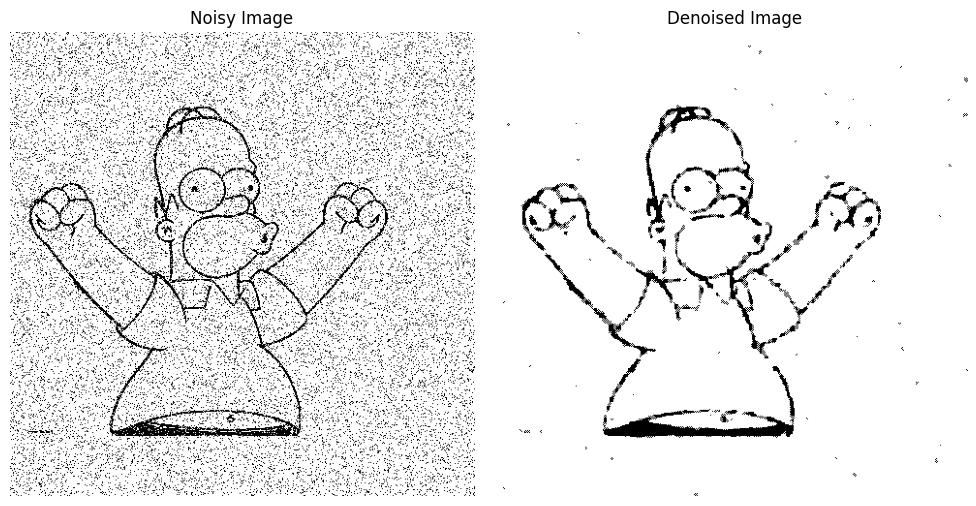

In [6]:
image_path = data_dir / "homer.png"

image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
crisp = denoise(image, 5, 0.6, burnin=5, iters=10)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image, cmap="gray")
axes[0].set_title("Noisy Image")
axes[0].axis("off")

axes[1].imshow(crisp, cmap="gray")
axes[1].set_title("Denoised Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## References

1. Rubenthaler, S. (2021). _An Introduction to Machine Learning with Probabilities, in R_. https://math.univ-cotedazur.fr/~rubentha/enseignement/poly-machine-learning.pdf.
